Loads data from the dataset and applies transformntions


In [4]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}

# set batch_size
batch_size = 24

# set number of workers
num_workers = 4

train_set = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=data_transforms['training'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=data_transforms['testing'])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

val_set = torchvision.datasets.Flowers102(root='./data', split="val", download=True, transform=data_transforms['validation'])
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)                                        
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


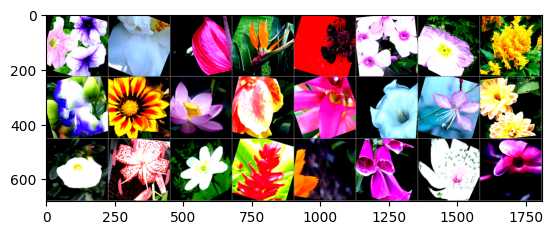

tensor(50)
tensor(95)
tensor(79)
tensor(7)
tensor(25)
tensor(31)
tensor(0)
tensor(26)
tensor(8)
tensor(70)
tensor(77)
tensor(89)
tensor(98)
tensor(74)
tensor(56)
tensor(59)
tensor(63)
tensor(5)
tensor(68)
tensor(23)
tensor(4)
tensor(93)
tensor(37)
tensor(31)


In [5]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
for i in range(batch_size):
  print(labels[i])

In [77]:
class Net(nn.Module):
	
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5) 
        self.bn2 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 53 * 53, 320)
        self.fc2 = nn.Linear(320, 240)
        self.fc3 = nn.Linear(240, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=240, bias=True)
  (fc3): Linear(in_features=240, out_features=102, bias=True)
)


In [72]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [73]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [74]:
from torch.autograd import Variable

def train(epoch_num, model):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        model.train()
        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            images = images.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            

        valid_loss = 0.0
        model.eval()
        for i, (images, labels) in enumerate(val_loader, 0):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            vloss = criterion(outputs, labels)
            valid_loss = vloss.item()*images.size(0)

        print(f'Epoch {epoch+1} \t\t Training Loss: {running_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        print("lr: ", get_lr(optimizer))
        #accuracy = testAccuracy(model)
        #print("\nepoch: ",epoch,"/",epoch_num," ... Loss: ",loss.item())
        #print('EPOCH:', epoch,'---> TEST ACCURACY: %d %%' % (accuracy))

        # validation dat

        #print("\nepoch: ",epoch,"/",epoch_num," ... Loss: ",loss.item()," VLoss: ", vloss.item())

        scheduler.step(running_loss)

    # whatever you are timing goes here
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()
    print(start.elapsed_time(end))  # milliseconds



In [26]:
def test(data, model):
    correct = 0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    with torch.no_grad():
        for value in data:
            images, labels = value
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [78]:
if __name__ == "__main__":
    
    # train the model with epoch number, model
    train(140, net)
    print('Finished Training')

    # Accuracy on training data
    test(train_loader, net)

    # Accuracy on valid data
    test(val_loader, net)

    # Accuracy on test data
    test(test_loader, net)
    

The model will be running on cuda:0 device
Epoch 1 		 Training Loss: 4.625682376151861 		 Validation Loss: 1.2855433087016261
lr:  0.001
Epoch 2 		 Training Loss: 4.626612441484318 		 Validation Loss: 1.2855433087016261
lr:  0.001
Epoch 3 		 Training Loss: 4.6259279916452805 		 Validation Loss: 1.2855433087016261
lr:  0.001


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


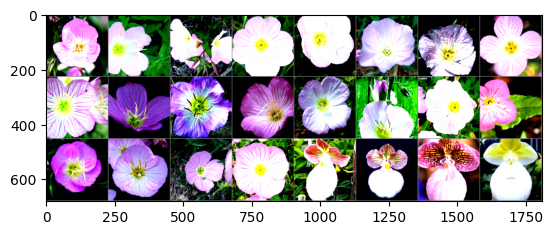

GroundTruth: 
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [42]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ')
for i in range(4):
  print(labels[i])

In [43]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

for i in range(4):
  print(predicted[i])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000232EE832C00>
Traceback (most recent call last):
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
correct = 0
total = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

The model will be running on cuda:0 device
Accuracy of the network on the 10000 test images: 31 %
